# Snake Game agents: learning and testing

In [1]:
# Import libraries
import pygame
import time
import random
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats

pygame 2.6.0 (SDL 2.28.4, Python 3.10.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Initialize Pygame
pygame.init()

# Set colors
black = (0, 0, 0)
white = (255, 255, 255)
red = (213, 50, 80)
green = (0, 255, 0)
blue = (50, 153, 213)

# Set display dimensions
width, height = 600, 400
display = pygame.display.set_mode((width, height))
pygame.display.set_caption('Snake Game')

# Set game clock
clock = pygame.time.Clock()

# Snake settings
snake_block = 10
snake_speed = 1000

# Font settings
font_style = pygame.font.SysFont("bahnschrift", 15)
score_font = pygame.font.SysFont("comicsansms", 25)
font_final = pygame.font.SysFont("bahnschrift", 25)

# fix the seed
random.seed(42)

In [3]:
# Rewards for our q-learning agent
reward_food = 10
punishment = -100
reward_nothing = 0
reward_right_direction = 1
reward_wrong_direction = -1

In [4]:
# Let's define class for our random agent that would choose direction uniformly: west, east, north or south 
class Random_Agent():
    def __init__(self):
        # Here we will keep results of games  
        self.results = []
        self.first_food = []
        self.steps = []
        self.steps_last_food = []
        self.games_played = 0
        
    def get_next_action(self, old_x_change, old_y_change):
#       parameters: old_x_change: last snake's change in x 
#                   old_y_change: last snake's change in y 
#       returns: new random step for snake in x and y

        # for first step have four random options
        if [old_x_change, old_y_change] == [0, 0]:
            action = random.randint(1, 4)
            if action == 1:
                x_change = -snake_block
                y_change = 0
            elif action == 2:
                x_change = +snake_block
                y_change = 0
            if action == 3:
                x_change = 0
                y_change = -snake_block   
            if action == 4:
                x_change = 0
                y_change = +snake_block   
        else:
            # for next steps have three random options
            action_index = random.randint(0, 2)
            poss_actions = [[snake_block, 0], [0, snake_block], [-snake_block, 0], [0, -snake_block]]
            poss_actions.remove(list(np.array([old_x_change, old_y_change])*-1))
            
            if action_index == 0:
                x_change, y_change = poss_actions[0]
            elif action_index == 1:
                x_change, y_change = poss_actions[1]
            elif action_index == 2: 
                x_change, y_change = poss_actions[2]
                
        return x_change, y_change
    
    def get_next_location(self, current_x, current_y, x_change, y_change):
#         parameters: current_x = last snake's x 
#                     current_y = last snake's y
#                     x_change: new step for snake in x
#                     y_change: new step for snake in y
#         returns new x and y for snake                
                        
        new_x = current_x + x_change  
        new_y = current_y + y_change
        
        return new_x, new_y

In [5]:
# Let's define class for our 'logic' agent that would follow implemented instructions
# These instructions will be written in q-value matrix
# This agent won't learn by itself, it will only choose the best action from q-value matrix 
class Logic_Agent():
    def __init__(self):
        # We will keep results here
        self.results = []
        self.first_food = []
        self.steps = []
        self.steps_last_food = []
        self.games_played = 0
        
        # We shall use the following q_values
        self.q_values = logic_q_values()
        
        
    def get_next_action(self, state, file):
        # parameter: state : current state of snake
        #            file: file to write in
        # returns: index of action to take (0 - forward, 1 - right, 2 - left)
        
        write_to_file(text=f'Look for argmax here: {self.q_values[tuple(state)]}\n', file=file)
        action_index = np.argmax(self.q_values[tuple(state)]) 
        write_to_file(text=f'Current action_index: {action_index}\n', file=file)
        
        return action_index
    
    def get_next_location(self, current_state, current_x, current_y, action_index):
#         parameters: current_state: current state of snake
#                     current_x: current x of snake
#                     current_y: current y of snake
#                     action_index: action to take
#         returns: new_direction (as a part of a new state) and new x, y of a snake                
                                    
        current_direction = current_state[3:7]  
        assert sum(current_direction) == 1

        if current_direction == [1, 0, 0, 0]:  # head is directed at west
            if action_index == 0:
                new_direction = [1, 0, 0, 0]
                new_x = current_x - snake_block 
                new_y = current_y 
            elif action_index == 1:
                new_direction = [0, 0, 1, 0]
                new_x = current_x 
                new_y = current_y - snake_block
            elif action_index == 2:
                new_direction = [0, 0, 0, 1]
                new_x = current_x 
                new_y = current_y + snake_block
        elif current_direction == [0, 1, 0, 0]: # head is directed at east
            if action_index == 0:
                new_direction = [0, 1, 0, 0]
                new_x = current_x + snake_block
                new_y = current_y
            elif action_index == 1:
                new_direction = [0, 0, 0, 1]
                new_x = current_x  
                new_y = current_y + snake_block
            elif action_index == 2:
                new_direction = [0, 0, 1, 0]
                new_x = current_x  
                new_y = current_y - snake_block
        elif current_direction == [0, 0, 1, 0]: # head is directed at north
            if action_index == 0:
                new_direction = [0, 0, 1, 0]
                new_x = current_x 
                new_y = current_y - snake_block 
            elif action_index == 1:
                new_direction = [0, 1, 0, 0]
                new_x = current_x + snake_block 
                new_y = current_y
            elif action_index == 2:
                new_direction = [1, 0, 0, 0]
                new_x = current_x - snake_block 
                new_y = current_y 
        elif current_direction == [0, 0, 0, 1]: # head is directed at south
            if action_index == 0:
                new_direction = [0, 0, 0, 1]
                new_x = current_x 
                new_y = current_y + snake_block 
            elif action_index == 1:
                new_direction = [1, 0, 0, 0]
                new_x = current_x - snake_block 
                new_y = current_y
            elif action_index == 2:
                new_direction = [0, 1, 0, 0]
                new_x = current_x + snake_block 
                new_y = current_y 

        return new_direction, new_x, new_y

In [6]:
def logic_q_values():
    # Returns q_value matrix filled with logic assumptions
        q_values = np.zeros([2]*11+[3])
        
        # Punishment for going to danger
        q_values[1, :, :, :, :, :, :, :, :, :, :] += [punishment, 0, 0]
        q_values[:, 1, :, :, :, :, :, :, :, :, :] += [0, punishment, 0]
        q_values[:, :, 1, :, :, :, :, :, :, :, :] += [0, 0, punishment]
        
        # Rewards if head is directed at west 
        q_values[:, :, :, 1, 0, 0, 0, 1, :, :, :] += [reward_right_direction, 0, 0]
        q_values[:, :, :, 1, 0, 0, 0, :, 1, :, :] += [reward_wrong_direction, 0, 0]
        q_values[:, :, :, 1, 0, 0, 0, :, :, 1, :] += [0, reward_right_direction, 0]
        q_values[:, :, :, 1, 0, 0, 0, :, :, :, 1] += [0, 0, reward_right_direction]

        # Rewards if head is directed at east
        q_values[:, :, :, 0, 1, 0, 0, 1, :, :, :] += [reward_wrong_direction, 0, 0]
        q_values[:, :, :, 0, 1, 0, 0, :, 1, :, :] += [reward_right_direction, 0, 0]
        q_values[:, :, :, 0, 1, 0, 0, :, :, 1, :] += [0, reward_wrong_direction, reward_right_direction]
        q_values[:, :, :, 0, 1, 0, 0, :, :, :, 1] += [0, reward_right_direction, reward_wrong_direction]

        # Rewards if head is directed at north
        q_values[:, :, :, 0, 0, 1, 0, 1, :, :, :] += [0, reward_wrong_direction, reward_right_direction]
        q_values[:, :, :, 0, 0, 1, 0, :, 1, :, :] += [0, reward_right_direction, reward_wrong_direction]
        q_values[:, :, :, 0, 0, 1, 0, :, :, 1, :] += [reward_right_direction, 0, 0]
        q_values[:, :, :, 0, 0, 1, 0, :, :, :, 1] += [0, 0, reward_wrong_direction]

        # Rewards if head is directed at south
        q_values[:, :, :, 0, 0, 0, 1, 1, :, :, :] += [0, reward_right_direction, reward_wrong_direction]
        q_values[:, :, :, 0, 0, 0, 1, :, 1, :, :] += [0, reward_wrong_direction, reward_right_direction]
        q_values[:, :, :, 0, 0, 0, 1, :, :, 1, :] += [reward_wrong_direction, 0, 0]
        q_values[:, :, :, 0, 0, 0, 1, :, :, :, 1] += [reward_right_direction, 0, 0]
        
        return q_values

In [7]:
# Let's define class for our q-learning agent that would learn by itself
# This agent will fill q-value matrix by playing the game
# At the same time it will take random action or the best action in current state
class Q_learning_Agent():
    def __init__(self, q_values=np.zeros([2]*11+[3])):
        # Here we will keep results 
        self.results = []
        self.first_food = []
        self.steps = []
        self.steps_last_food = []
        self.games_played = 0
        
        # We will use the following parameters for q-learning
        self.epsilon = 0 #the percentage of time when we should take a random action (instead of the best action)
        self.epsilon_discount = 0.999 # rate at which epsilon should reduce 
        self.min_epsilon = 0.001 # minimum percentage of time when we should take a random action (instead of the best action)
        self.discount_factor = 0.05 #discount factor for future rewards
        self.learning_rate = 0.9 #the rate at which the AI agent should learn
        self.q_values = q_values # emmpty q-value matrix
        
    #define an epsilon greedy algorithm that will choose which action to take next (i.e., where to move next)
    def get_next_action(self, state, file):
        # parameter: state : current state of snake
        #            file: file to write in
        # returns: index of action to take (0 - forward, 1 - right, 2 - left)
        
        #if a randomly chosen value between 0 and 1 is less than epsilon,
        #then choose the most promising value from the Q-table for this state
        if np.random.random() > self.epsilon:
            write_to_file(text=f'Look for argmax here: {self.q_values[tuple(state)]}\n', file=file)
            action_index = np.argmax(self.q_values[tuple(state)]) 
            write_to_file(text=f'Current action_index: {action_index}\n', file=file)
            

        else: #choose a random action
            write_to_file(text='Explore\n', file=file)
            action_index = np.random.randint(0, 3)
            write_to_file(text=f'Current action_index: {action_index}', file=file)
            
        return action_index
    
    def get_next_location(self, current_state, current_x, current_y, action_index):
        # parameters: current_state: current state of snake
        #             current_x: current x of snake
        #             current_y: current y of snake
        #             action_index: action to take
        # returns: new_direction (as a part of a new state) and new x, y of a snake
        
        current_direction = current_state[3:7]  
        assert sum(current_direction) == 1

        if current_direction == [1, 0, 0, 0]: # head is directed at west
            if action_index == 0:
                new_direction = [1, 0, 0, 0]
                new_x = current_x - snake_block 
                new_y = current_y 
            elif action_index == 1:
                new_direction = [0, 0, 1, 0]
                new_x = current_x 
                new_y = current_y - snake_block
            elif action_index == 2:
                new_direction = [0, 0, 0, 1]
                new_x = current_x 
                new_y = current_y + snake_block
        elif current_direction == [0, 1, 0, 0]: # head is directed at east
            if action_index == 0:
                new_direction = [0, 1, 0, 0]
                new_x = current_x + snake_block
                new_y = current_y
            elif action_index == 1:
                new_direction = [0, 0, 0, 1]
                new_x = current_x  
                new_y = current_y + snake_block
            elif action_index == 2:
                new_direction = [0, 0, 1, 0]
                new_x = current_x  
                new_y = current_y - snake_block
        elif current_direction == [0, 0, 1, 0]: # head is directed at north
            if action_index == 0:
                new_direction = [0, 0, 1, 0]
                new_x = current_x 
                new_y = current_y - snake_block 
            elif action_index == 1:
                new_direction = [0, 1, 0, 0]
                new_x = current_x + snake_block 
                new_y = current_y
            elif action_index == 2:
                new_direction = [1, 0, 0, 0]
                new_x = current_x - snake_block 
                new_y = current_y 
        elif current_direction == [0, 0, 0, 1]: # head is directed at south
            if action_index == 0:
                new_direction = [0, 0, 0, 1]
                new_x = current_x 
                new_y = current_y + snake_block 
            elif action_index == 1:
                new_direction = [1, 0, 0, 0]
                new_x = current_x - snake_block 
                new_y = current_y
            elif action_index == 2:
                new_direction = [0, 1, 0, 0]
                new_x = current_x + snake_block 
                new_y = current_y 

        return new_direction, new_x, new_y

In [8]:
def your_score(score, games_played, average):
    # function to draw score on the screen
    value = score_font.render(f'Score: {str(score)} | Game: {str(games_played)} | Mean_100: {round(average, 1)}', True, white)
    display.blit(value, [0, 0])


def our_snake(snake_block, snake_list):
    # function to draw snake on the screen
    for x in snake_list:
        pygame.draw.rect(display, black, [x[0], x[1], snake_block, snake_block])


def message(msg, color):
    # function to write message on the screen
    mesg = font_style.render(msg, True, color)
    display.blit(mesg, [width / 6, height / 3])
    
    
def get_starting_location():
    # function to choose a random, non-terminal starting location
    current_row_index = width / 2
    current_column_index = height / 2
    return current_row_index, current_column_index

In [9]:
def border_locating(x, y, direction):
    # function that identifies border location in a format of state
    # parameters: x: current x of snake's head
    #             y: current y of snake's head
    #            directon: at what direction is the head directed
    # returns: states of border
    
    border = [0, 0, 0]
    if x == 0:
        if direction[0] == 1:
            border[0] = 1
        elif direction[2] == 1:
            border[2] = 1
        elif direction[3] == 1:
            border[1] = 1
    if (x + snake_block) == width:
        if direction[1] == 1:
            border[0] = 1
        elif direction[2] == 1:
            border[1] = 1
        elif direction[3] == 1:
            border[2] = 1
    if y == 0:
        if direction[0] == 1:
            border[1] = 1
        elif direction[1] == 1:
            border[2] = 1
        elif direction[2] == 1:
            border[0] = 1
    if (y + snake_block) == height:
        if direction[0] == 1:
            border[2] = 1
        elif direction[1] == 1:
            border[1] = 1
        elif direction[3] == 1:
            border[0] = 1
    return border

def body_locating(x, y, direction, snake_list):
    # function that identifies body location in a format of state
    # parameters: x: current x of snake's head
    #             y: current y of snake's head
    #            directon: at what direction is the head directed
    # returns: states of body
    
    body = [0, 0, 0]
    if direction == [1, 0, 0, 0]:
        for a in snake_list[:-1]:
            if a == [x-snake_block, y]:
                body[0] = 1
            if a == [x, y-snake_block]:
                body[1] = 1
            if a == [x, y+snake_block]:
                body[2] = 1
                
    if direction == [0, 1, 0, 0]:
        for a in snake_list[:-1]:
            if a == [x+snake_block, y]:
                body[0] = 1
            if a == [x, y+snake_block]:
                body[1] = 1
            if a == [x, y-snake_block]:
                body[2] = 1
                
    if direction == [0, 0, 1, 0]:
        for a in snake_list[:-1]:
            if a == [x, y-snake_block]:
                body[0] = 1
            if a == [x+snake_block, y]:
                body[1] = 1
            if a == [x-snake_block, y]:
                body[2] = 1

    if direction == [0, 0, 0, 1]:
        for a in snake_list[:-1]:
            if a == [x, y+snake_block]:
                body[0] = 1
            if a == [x-snake_block, y]:
                body[1] = 1
            if a == [x+snake_block, y]:
                body[2] = 1
                
    return body

        
def food_locating(x, y, food_x, food_y):
    # function that identifies food location in a format of state
    
    # parameters: x: current x of snake's head
    #             y: current y of snake's head
    #            directon: at what direction is the head directed
    # returns: states of food
    
    food_state = [0]*4
    if x < food_x:
        food_state[1] = 1
    elif x > food_x:
        food_state[0] = 1
        
    if y < food_y:
        food_state[3] = 1
    elif y > food_y:
        food_state[2] = 1
    
    return food_state

def right_step(current_x, current_y, old_x, old_y, food_x, food_y):
    # function that identifies whether last step made the snake closer to the food
    # parameters: x: current x of snake's head
    #             y: current y of snake's head
    #             old_x: previous x of snake's head
    #             old_y: previos y of snake's head
    #             food_x: current x of food
    #             food_y: current y of food
    # returns: True or False
    
    new2food_x = abs(food_x - current_x)
    new2food_y = abs(food_y - current_y)
    
    old2food_x = abs(food_x - old_x)
    old2food_y = abs(food_y - old_y)
    
    if new2food_x + new2food_y < old2food_x + old2food_y:
        return True
    else:
        return False
    
def write_to_file(text, file=None):
    if file:
        file.write(text)

In [10]:
def start_games(agent, save, n_games, learn, file_to_write=None):
    # function where agent plays games and learns (if it cans)
    # parameters: agent: random, logic or q-learning
    #             save: True if interim versions of the agent should be saved  
    #             n_games: number of games to be played
    #             learn: True if the agent can learn
    # returns: agent with history of its games
    
    file = file_to_write
    if file_to_write:
        file = open(file_to_write, "w")
    
    # Let's stop when enough games are played
    while agent.games_played < n_games:
#       Let's define initial position of the game
        write_to_file(text='---------------------------------------------\n', file=file)
        game_over = False
        game_close = False
        first_food_eaten = False
        steps_without_food = 0 
        steps_last_food = 0
        steps = 0
        agent.games_played += 1
        write_to_file(text=f'Game #{agent.games_played}\n', file=file)
        
        x, y = get_starting_location()
        state = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
        x_change, y_change = 0, 0
        
        snake_List = []
        Length_of_snake = 1

        food_x = round(random.randint(0, width - snake_block) / snake_block) * snake_block
        food_y = round(random.randint(0, height - snake_block) / snake_block) * snake_block

        state[-4:] = food_locating(x, y, food_x, food_y)
        
        write_to_file(text=f'Start state: {state}\n', file=file)
        write_to_file(text=f'Start snake location: {(x, y)}\n', file=file)
        write_to_file(text=f'Start food location: {(food_x, food_y)}\n', file=file)

#       Let's discount the epsilon for current game   
        if type(agent) == Q_learning_Agent:
            agent.eps = max(agent.epsilon * agent.epsilon_discount, agent.min_epsilon)

        # Make new steps while the game is not over    
        while not game_over:

            if type(agent) == Random_Agent:
                #choose which action to take (i.e., where to move next
                x_change, y_change = agent.get_next_action(x_change, y_change)
                #perform the chosen action, and transition to the next state (i.e., move to the next location)
                x, y = agent.get_next_location(x, y, x_change, y_change)

            if type(agent) == Q_learning_Agent or type(agent) == Logic_Agent:
                #choose which action to take (i.e., where to move next)
                action_index = agent.get_next_action(state, file)

                #perform the chosen action, and transition to the next state (i.e., move to the next location)
                old_state, old_x, old_y = state, x, y #store the old row and column indexes
                direction_state, x, y = agent.get_next_location(state, x, y, action_index)
                del state

                
            steps += 1
            steps_without_food += 1

            display.fill(blue)
            pygame.draw.rect(display, green, [food_x, food_y, snake_block, snake_block])

            # snake list update
            snake_Head = []
            snake_Head.append(x)
            snake_Head.append(y)
            snake_List.append(snake_Head)

            if len(snake_List) > Length_of_snake:
                del snake_List[0]

            reward = reward_nothing

            our_snake(snake_block, snake_List)
            your_score(Length_of_snake - 1, agent.games_played, np.mean(agent.results[-100:]))

            pygame.display.update()

    #       Check whether snake ate food and define a reward for the last step
            if x == food_x and y == food_y:
                if not first_food_eaten:
                    first_food = steps_without_food
                    agent.first_food.append(first_food)
                    first_food_eaten = True
                    
                
                steps_last_food += steps_without_food    
                steps_without_food = 0
                
                # Food should not be generated at snake body
                while True:
                    food_x = round(random.randint(0, width - snake_block) / snake_block) * snake_block
                    food_y = round(random.randint(0, height - snake_block) / snake_block) * snake_block

                    if [food_x, food_y] not in snake_List:
                        break

                Length_of_snake += 1
                reward = reward_food
                food_state = food_locating(x, y, food_x, food_y)
                write_to_file(text='Food was eaten\n', file=file)
                
            elif type(agent) == Q_learning_Agent or type(agent) == Logic_Agent:
                if right_step(x, y, old_x, old_y, food_x, food_y):
                    reward = reward_right_direction
                else:
                    reward = reward_wrong_direction
                food_state = food_locating(x, y, food_x, food_y)
                

    #       Check whether snake bit itself    
            for a in snake_List[:-1]:
                if a == snake_Head:
                    game_over = True
                    reward = punishment
                    write_to_file(text='Snake bit itself\n', file=file)

    #       Check whether snake hit the boundaries
            if x >= width or x < 0 or y >= height or y < 0:
                game_over = True
                reward = punishment
                write_to_file(text='Snake hit the boundaries\n', file=file)
                
    #       Check whther snake stuck in a loop
            if steps_without_food >= 1000:
                game_over = True

            # Let's update the danger state    
            if type(agent) == Q_learning_Agent or type(agent) == Logic_Agent:
                danger_state = list(np.array(border_locating(x, y, direction_state)) \
                                             +np.array(body_locating(x, y, direction_state, snake_List)))

                state = danger_state + direction_state + food_state
                
                write_to_file(text=f'Current state: {state}\n', file=file)
                write_to_file(text=f'Current snake location: {(x, y)}\n', file=file)
                write_to_file(text=f'Current food location: {(food_x, food_y)}\n', file=file)


    #       Let's update q_values matrix if an agent is able to    
            if learn:
                #receive the reward for moving to the new state, and calculate the temporal difference
                write_to_file(text=f'Reward for the last step: {reward}\n', file=file)
                old_q_value = agent.q_values[tuple(old_state+[action_index])]
                if game_over:
                    # if game is over, expected_reward is equal to 0
                    current_exp_reward = 0
                else:
                    current_exp_reward = np.max(agent.q_values[tuple(state)])                
                temporal_difference = reward + agent.discount_factor * current_exp_reward - old_q_value
                #update the Q-value for the previous state and action pair
                new_q_value = old_q_value + (agent.learning_rate * temporal_difference)
                agent.q_values[tuple(old_state+[action_index])] = new_q_value
                write_to_file(text=f'New q at {old_state}: {agent.q_values[tuple(old_state)]}\n', file=file)

        # Let's check wether game is over        
        while game_over == True:
            # display update
            display.fill(blue)
            final_text = font_final.render("You Lost! Press C-Play Again or Q-Quit", True, red)
            display.blit(final_text, [width / 6, height / 3 + 30]) 
            
            # Append new result 
            agent.results.append(Length_of_snake - 1)
            agent.steps.append(steps)
            if first_food_eaten:
                agent.steps_last_food.append(steps_last_food)
            your_score(Length_of_snake - 1, agent.games_played, np.mean(agent.results[-100:]))
            write_to_file(text='\n', file=file)
            write_to_file(text=f'Score: {Length_of_snake - 1}\n', file=file)
            pygame.display.update()

            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    game_over = False
                    game_close = True

            # Saving an agent if needed
            if save:
                if agent.games_played % 100 == 0:
                    with open(f"q_agent_{agent.games_played}.pickle", "wb") as f:
                      pickle.dump(q_agent, f)

                
            game_over = False
            time.sleep(1)    

            clock.tick(snake_speed)

    return agent

In [11]:
# Start the game loop for random agent
random_agent = Random_Agent()
random_agent = start_games(random_agent, save=False, n_games=100, learn=False)

C:\Users\ilyak\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ilyak\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [12]:
# Start the game loop for logic agent
logic_agent = Logic_Agent()
logic_agent = start_games(logic_agent, save=False, n_games=100, learn=False)

In [13]:
# Start train q-agent
q_agent = Q_learning_Agent()
q_agent = start_games(q_agent, save=False, n_games=600, learn=True, file_to_write='q_agent_learning.txt')

In [14]:
# Start the game loop for q-agent
q_agent_trained = Q_learning_Agent(q_values=q_agent.q_values)
q_agent_trained = start_games(q_agent_trained, save=False, n_games=100, learn=False)

In [18]:
def statistics(data1, data2, data3, name1, name2):
    # Built histograms
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.hist(data1, bins=10, edgecolor='black')
    plt.title(f'Random agent {name1}')
    plt.xlabel(name2)
    plt.ylabel('Number of games')

    plt.subplot(132)
    plt.hist(data2, bins=10, edgecolor='black')
    plt.title(f'Logic agent {name1}')
    plt.xlabel(name2)
    plt.ylabel('Number of games')

    plt.subplot(133)
    plt.hist(data3, bins=10, edgecolor='black')
    plt.title(f'Q-agent {name1}')
    plt.xlabel(name2)
    plt.ylabel('Number of games')

    plt.tight_layout()
    plt.show()

    # Create dictionary with data
    dic = {'Random agent': np.array(data1), 'Logic agent': np.array(data2), 'Q-agent': np.array(data3)}

    # Вычисляем статистические показатели
    stats_df = pd.DataFrame(index=['min', 'max', 'mean', 'mode', 'median', 'std', 'n games'])

    for col in dic.keys():
      stats_df[col] = [round(dic[col].min(), 1), 
               round(dic[col].max(), 1), 
               round(dic[col].mean(), 1), 
               round(stats.mode(dic[col])[0], 1),
               round(np.median(dic[col]), 1),
               round(dic[col].std(), 1),
               len(dic[col])]
    
    return stats_df

# Here are statistics of scores 

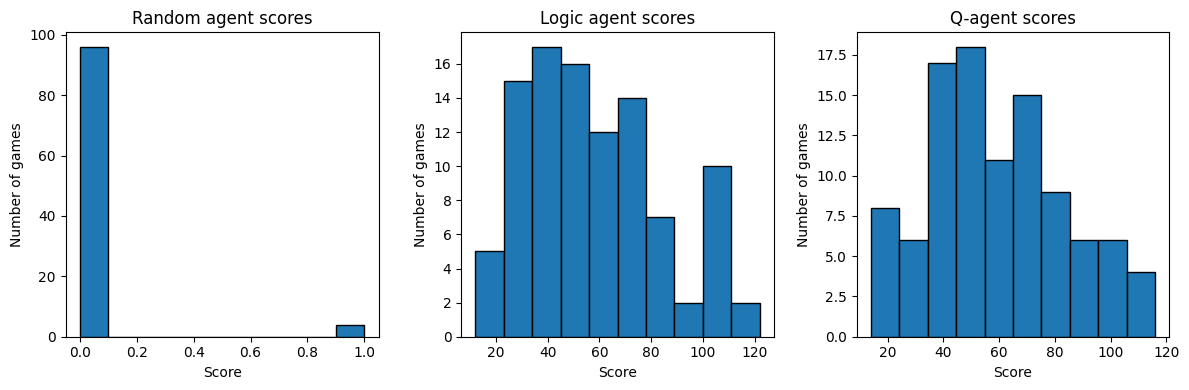

,Random agent,Logic agent,Q-agent
min,0.0,12.0,14.0
max,1.0,122.0,116.0
mean,0.0,57.8,58.8
mode,0.0,31.0,49.0
median,0.0,54.0,55.5
std,0.2,26.0,24.4
n games,100.0,100.0,100.0


In [19]:
stats_df = statistics(data1=random_agent.results, data2=logic_agent.results, data3=q_agent.results[-100:], name1='scores', name2='Score')
stats_df

# Here are statistics of steps till death

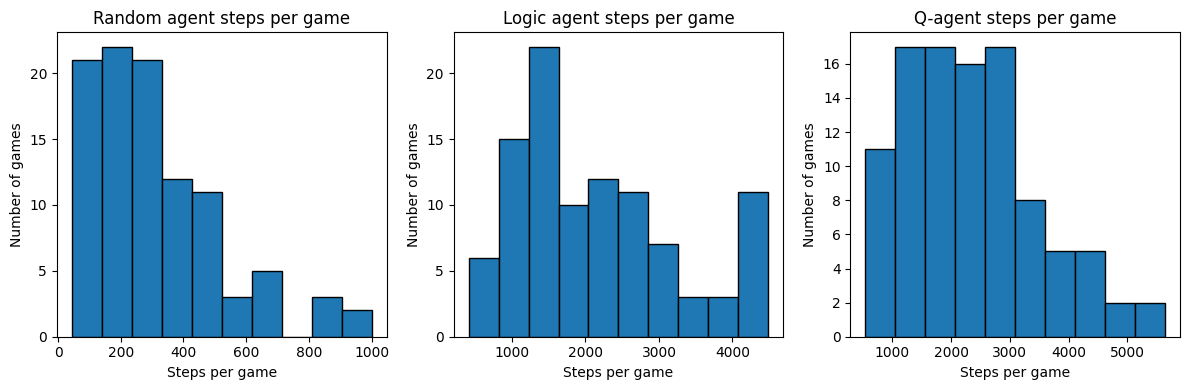

,Random agent,Logic agent,Q-agent
min,44.0,409.0,541.0
max,1000.0,4488.0,5638.0
mean,309.0,2163.7,2348.1
mode,128.0,4158.0,1488.0
median,252.0,1975.5,2227.0
std,211.2,1088.8,1137.5
n games,100.0,100.0,100.0


In [20]:
stats_df = statistics(data1=random_agent.steps, data2=logic_agent.steps, data3=q_agent.steps[-100:], name1='steps per game', name2='Steps per game')
stats_df

# Here are statistics of steps to get first food

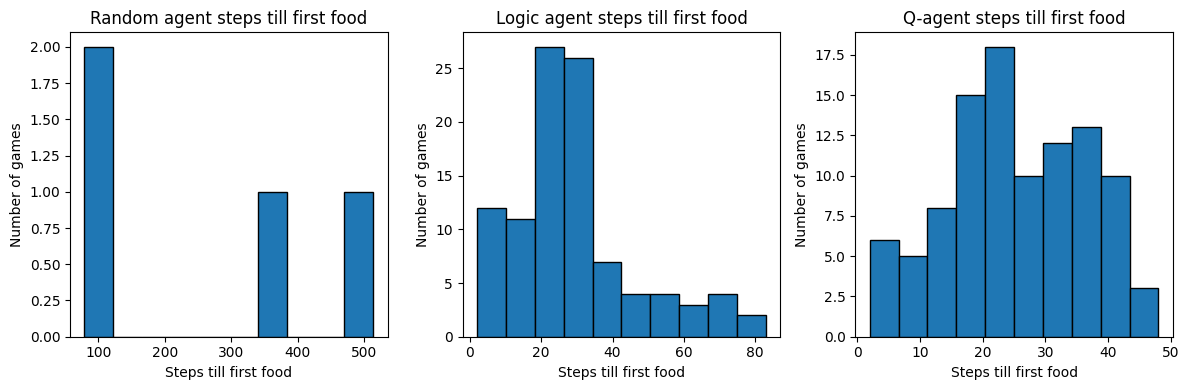

,Random agent,Logic agent,Q-agent
min,79.0,2.0,2.0
max,514.0,83.0,48.0
mean,273.0,29.2,25.3
mode,79.0,21.0,23.0
median,249.5,27.0,24.0
std,180.2,16.9,11.0
n games,4.0,100.0,100.0


In [21]:
stats_df = statistics(data1=random_agent.first_food, data2=logic_agent.first_food, data3=q_agent.first_food[-100:], name1='steps till first food', name2='Steps till first food')
stats_df

# Here are statistics for average number of steps to get food

In [22]:
def div_list(list1, list2):
    list1 = [num for num in list1 if num != 0]
    list2 = [num for num in list2 if num != 0]
    assert len(list1) == len(list2)
    
    list3 = []
    for i in range(len(list1)):
        list3.append(round(list1[i]/list2[i], 1))
    return list3

In [23]:
ra = div_list(random_agent.steps_last_food, random_agent.results)
la = div_list(logic_agent.steps_last_food, logic_agent.results)
qa = div_list(q_agent.steps_last_food, q_agent.results)

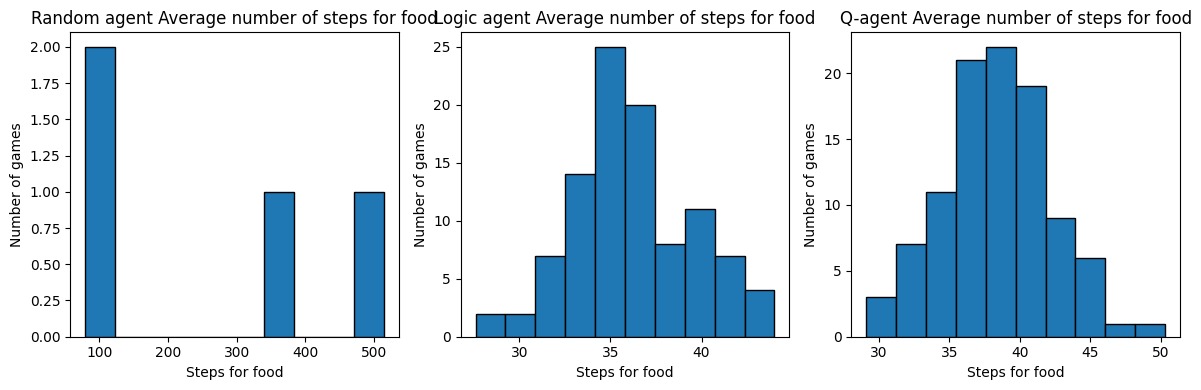

,Random agent,Logic agent,Q-agent
min,79.0,27.6,29.1
max,514.0,44.0,50.3
mean,273.0,36.1,38.4
mode,79.0,35.5,35.8
median,249.5,35.8,38.1
std,180.2,3.3,3.8
n games,4.0,100.0,100.0


In [24]:
stats_df = statistics(data1=ra, data2=la, data3=qa[-100:], name1='Average number of steps for food', name2='Steps for food')
stats_df

In [25]:
pygame.quit()
quit()